# "ArviZ in depth: plot_trace"
> Who said looking at traces wasn't fun?

- toc: true 
- author: Oriol Abril Pla
- badges: true
- categories: [arviz, visualization, plotting]
- image: images/nb/plot_trace_purple.png

## Introduction
`plot_trace` is one of the most common plots to assess the convergence of MCMC runs, therefore, it is also one of the most used ArviZ functions. `plot_trace` has a lot of parameters that allow creating highly customizable plots, but they may not be straightforward to use. There are many reasons that can explain this convolutedness of the arguments and their format, there is no clear culprit: ArviZ has to integrate with several libraries such as xarray and matplotlib which provide amazing features and customization power, and we'd like to allow ArviZ users to access all these features. However, we also aim to keep ArviZ usage simple and with sensible defaults; `plot_xyz(idata)` should generate acceptable results in most situations.

This post aims to be an extension to the API section on [`plot_trace`](https://arviz-devs.github.io/arviz/generated/arviz.plot_trace.html#arviz.plot_trace), focusing mostly on arguments where examples may be lacking and arguments that appear often in questions posted to ArviZ issues.

Therefore, the most common arguments such as `var_names` will not be covered, and for arguments that I do not remeber appearing in issues or generating confusion only some examples will be shown without an in depth description.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# html render is not correctly rendered in blog, 
# comment the line below if in jupyter
xr.set_options(display_style="text")  

rng = np.random.default_rng()

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
idata_centered = az.load_arviz_data("centered_eight")
idata = az.load_arviz_data("rugby")

## The `kind` argument
`az.plot_trace` generates two columns. The left one calls `plot_dist` to plot KDE/Histogram of the data, and the right column can contain either the trace itself (which gives the name to the plot) or a rank plot for which two visualizations are available. Rank plots are an alternative to trace plots, see https://arxiv.org/abs/1903.08008 for more details.

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


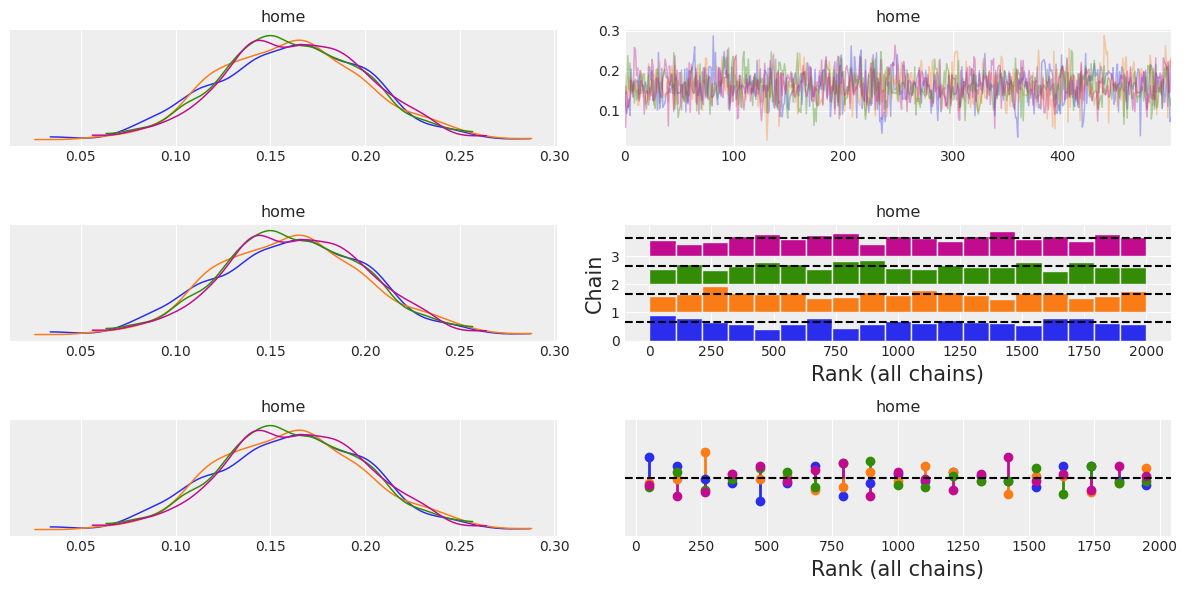

In [4]:
fig, axes = plt.subplots(3,2, figsize=(12,6))
for i, kind in enumerate(("trace", "rank_bars", "rank_vlines")):
    az.plot_trace(idata, var_names="home", kind=kind, ax=axes[i,:]);
fig.tight_layout()

## The `divergences` argument
If present, divergences are indicated as a black rugplot in both columns of the trace plot. By default they are placed at the bottom of the plot, but they can be placed at the top or hidden.

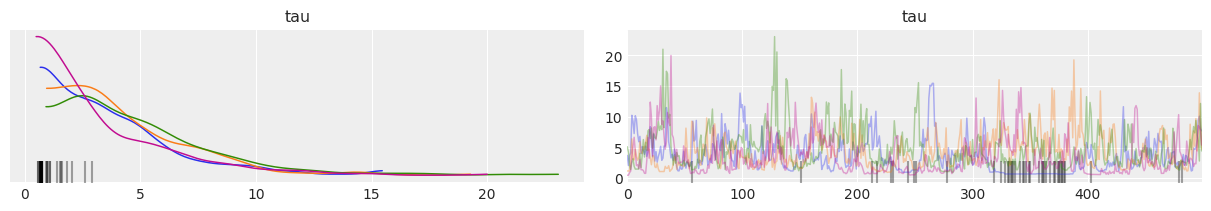

In [5]:
az.plot_trace(idata_centered, var_names="tau");

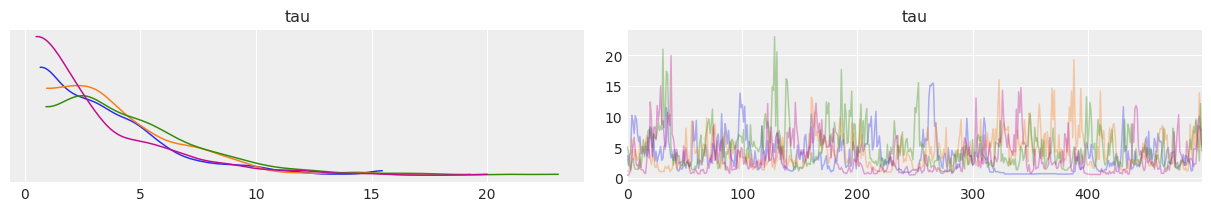

In [6]:
az.plot_trace(idata_centered, var_names="tau", divergences=None);

## The `rug` argument
`rug` adds a rug plot with the posterior samples at the bottom of the distribution plot, there are no changes in the trace plot column.

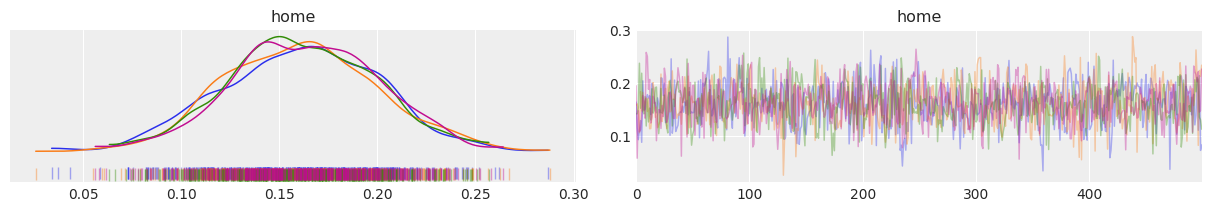

In [7]:
ax = az.plot_trace(idata, var_names="home", rug=True, rug_kwargs={"alpha": .4})

But what about having both rug and divergences at the same time? Fear not, ArviZ automatically modifies the default for divergences from `bottom` to `top` to prevent rug and divergences from overlapping:

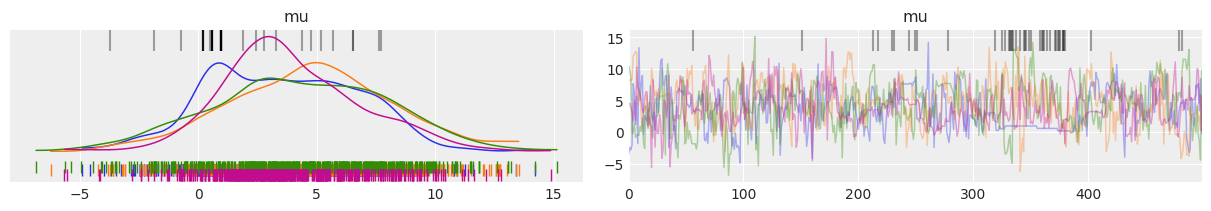

In [8]:
az.plot_trace(idata_centered, var_names="mu", rug=True);

## The `lines` argument
The description about lines in `plot_trace`'s docstring is the following: 

<blockquote><p>lines : <i>list of tuple of (str, dict, array_like), optional</i></p>
<p>
    List of <code>(var_name, {‘coord’: selection}, [line, positions])</code> to be overplotted as vertical lines on the density and horizontal lines on the trace.</p>
</blockquote>

It is possible that the first thought after reading this line is similar to _"What is with this weird format?"_ Well, this format is actually the stardard way ArviZ uses to iterate over `xarray.Dataset` objects because it contains all the info about the variable and the selected coordinates as well as the values themselves. The main helper function that handles this is `arviz.plots.plot_utils.xarray_var_iter`. 

This section will be a little different from the other ones, and will focus on boosting `plot_trace` capabilities with internal ArviZ functions. You may want to skip to the section altogether of go straigh to the end.

Let's see what `xarray_var_iter` does with a simple dataset. We will create a dataset with two variables: `a` will be a 2x3 matrix and `b` will be a scalar. In addition, the dimensions of `a` will be labeled.

In [9]:
ds = xr.Dataset({
    "a": (("pos", "direction"), rng.normal(size=(2,3))),
    "b": 12, 
    "pos": ["top", "bottom"],
    "direction": ["x", "y", "z"]
})
ds

<xarray.Dataset>
Dimensions:    (direction: 3, pos: 2)
Coordinates:
  * pos        (pos) <U6 'top' 'bottom'
  * direction  (direction) <U1 'x' 'y' 'z'
Data variables:
    a          (pos, direction) float64 -0.5306 0.8029 0.7965 ... 0.4623 -0.128
    b          int64 12

In [10]:
from arviz.plots.plot_utils import xarray_var_iter
for var_name, sel, values in xarray_var_iter(ds):
    print(var_name, sel, values)

a {'pos': 'top', 'direction': 'x'} -0.5306128314326483
a {'pos': 'top', 'direction': 'y'} 0.8029249611338745
a {'pos': 'top', 'direction': 'z'} 0.7965222104405889
a {'pos': 'bottom', 'direction': 'x'} -1.4255055469706215
a {'pos': 'bottom', 'direction': 'y'} 0.4622636712711883
a {'pos': 'bottom', 'direction': 'z'} -0.12804707435886095
b {} 12


`xarray_var_iter` has iterated over every single scalar value without loosing track of where did every value come from. We can also modify the behaviour to skip some dimensions (i.e. in ArviZ we generally iterate over data dimensions and skip `chain` and `draw` dims). 

In [11]:
for var_name, sel, values in xarray_var_iter(ds, skip_dims={"direction"}):
    print(var_name, sel, values)

a {'pos': 'top'} [-0.53061283  0.80292496  0.79652221]
a {'pos': 'bottom'} [-1.42550555  0.46226367 -0.12804707]
b {} 12


Now that we know about `xarray_var_iter` and what it does, we can use it to generate a list in the required format directly from xarray objects. Let's say for example we were interested in plotting the mean as a line in the trace plot:

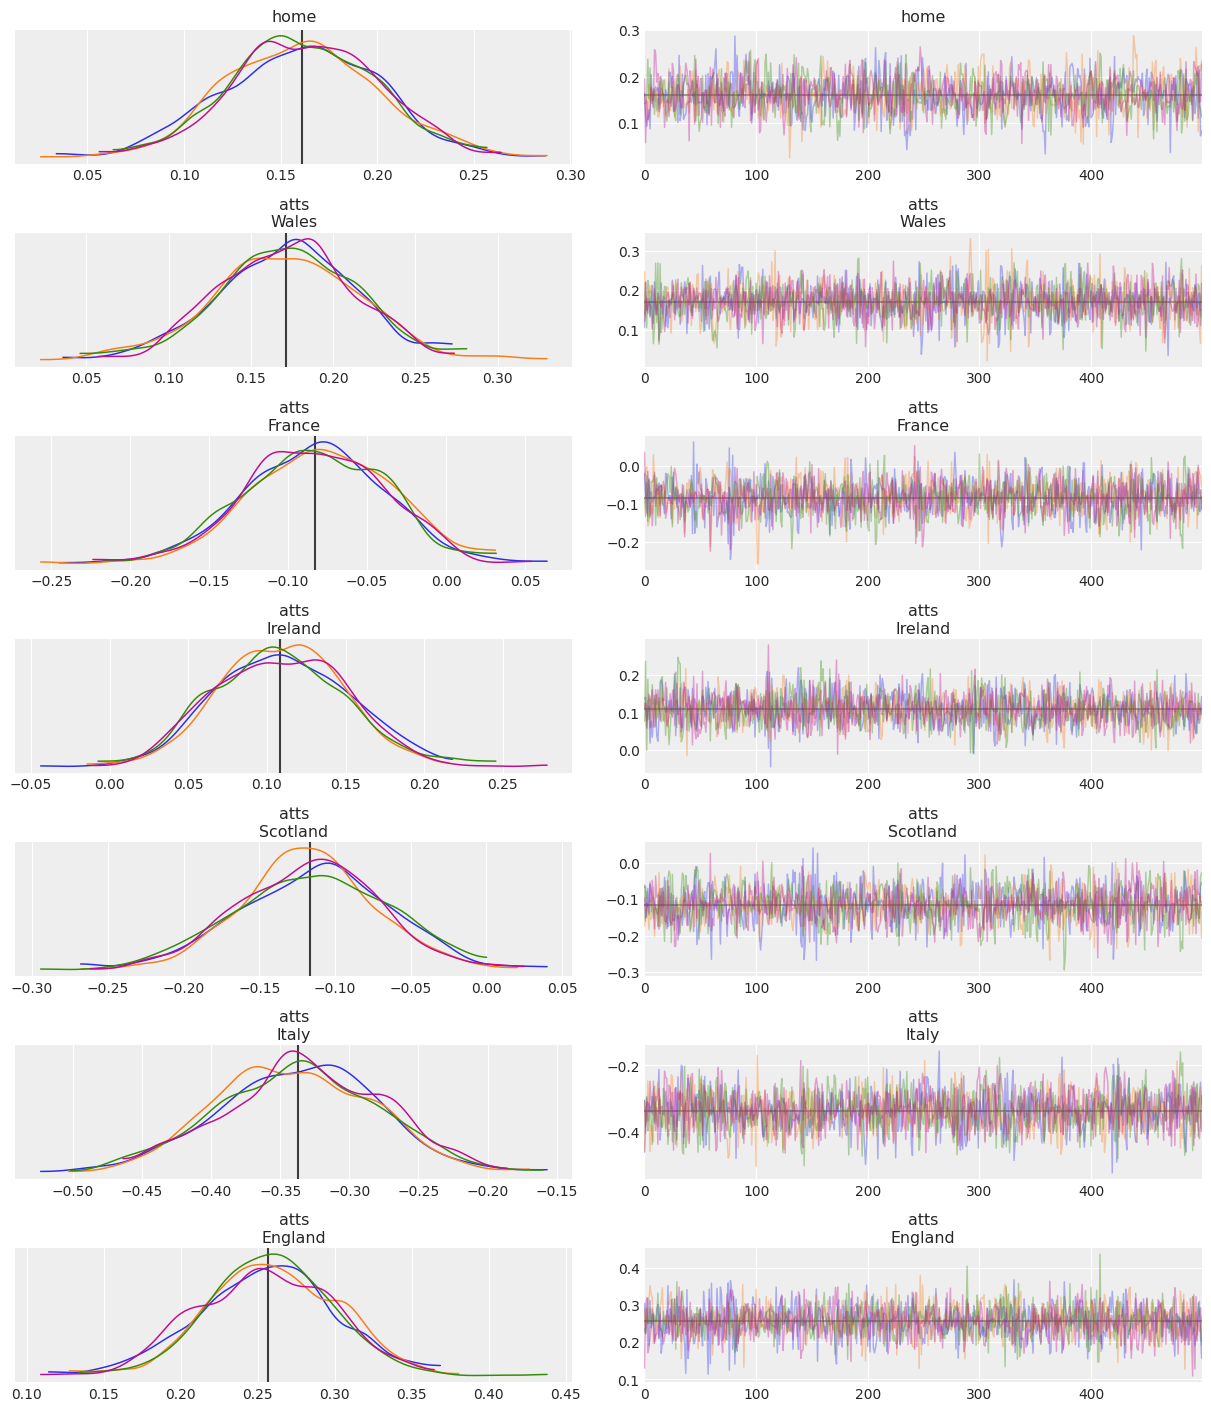

In [12]:
var_names = ["home", "atts"]
lines = list(xarray_var_iter(idata.posterior[var_names].mean(dim=("chain", "draw"))))
az.plot_trace(idata, var_names=var_names, lines=lines);

And what about quantile lines? Lets plot the 10% and 90% quantile lines but only for defs variable:

> Note: This same approach can also be used with `az.hdi` skipping `hdi` dimension

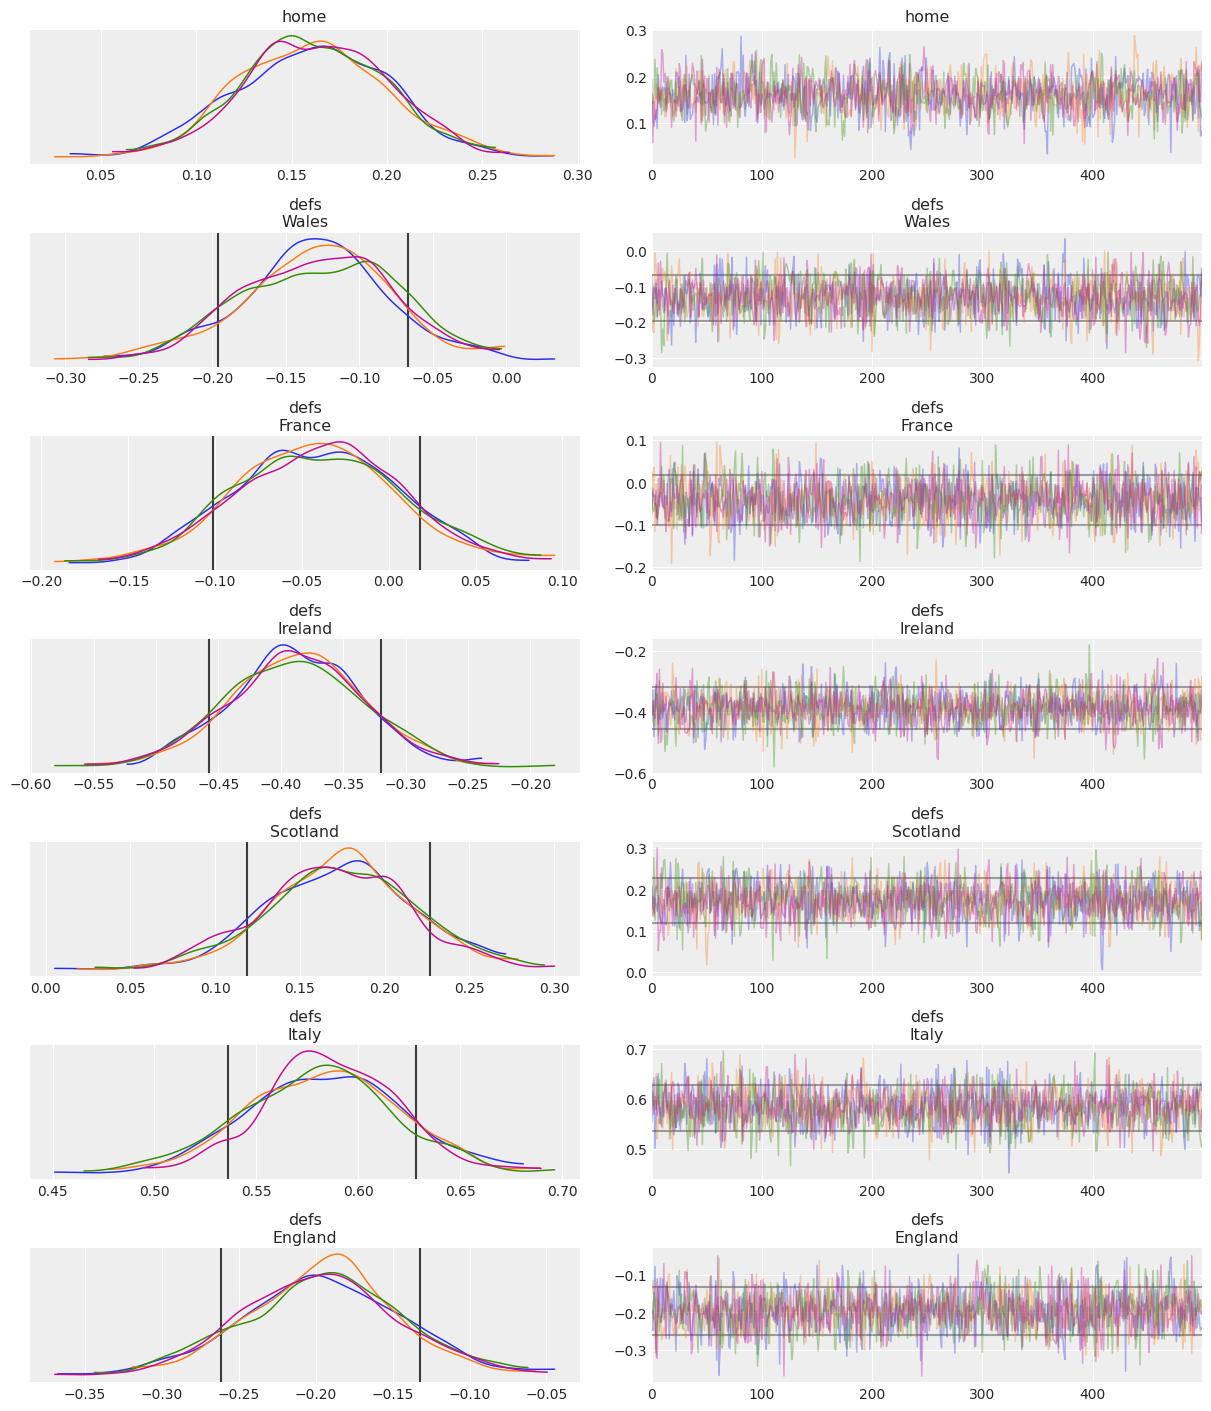

In [13]:
var_names = ["home", "defs"]
quantile_ds = idata.posterior[["defs"]].quantile((.1, .9), dim=("chain", "draw"))
lines = list(xarray_var_iter(quantile_ds, skip_dims={"quantile"}))
az.plot_trace(idata, var_names=var_names, lines=lines);

## Aggregation kwargs
This section is dedicated to 5 different kwargs, closely related to each other: `compact`+`compact_prop`, `combined`+`chain_prop` and `legend`. If we focus on the distribution plots of the left column, we may want to aggregate data along 2 possible dimensions, chains or variable dimension(s) -- school dimension in `centered_eight` data, team dimension in `rugby` data... As aggragation or not along these 2 possible dimensions is independent, we end up with 4 possibilities. 

In `az.plot_trace`, the argument `combined` governs the aggregation of all chains into a single plot (has no effect in trace, only in distributions), and `compact` governs the aggregation of the variable dimension(s). In order to be able to distinguish each single line after some aggregation has taken place, a `legend` argument is also available to show the legend with the data labels. `chain_prop` and `compact_prop` allow customization of the aesthetics mapping.

We'll now cover all 4 possibilities to showcase all supported cases and explore related customizations.

### `combined=False` and `compact=False`
The default behaviour of `plot_trace` is to perform no aggregation at all. In this case therefore, all subplots will have exactly one line per chain in the posterior. In this chain only setting, the default mapping is to use color to distinguish chains:

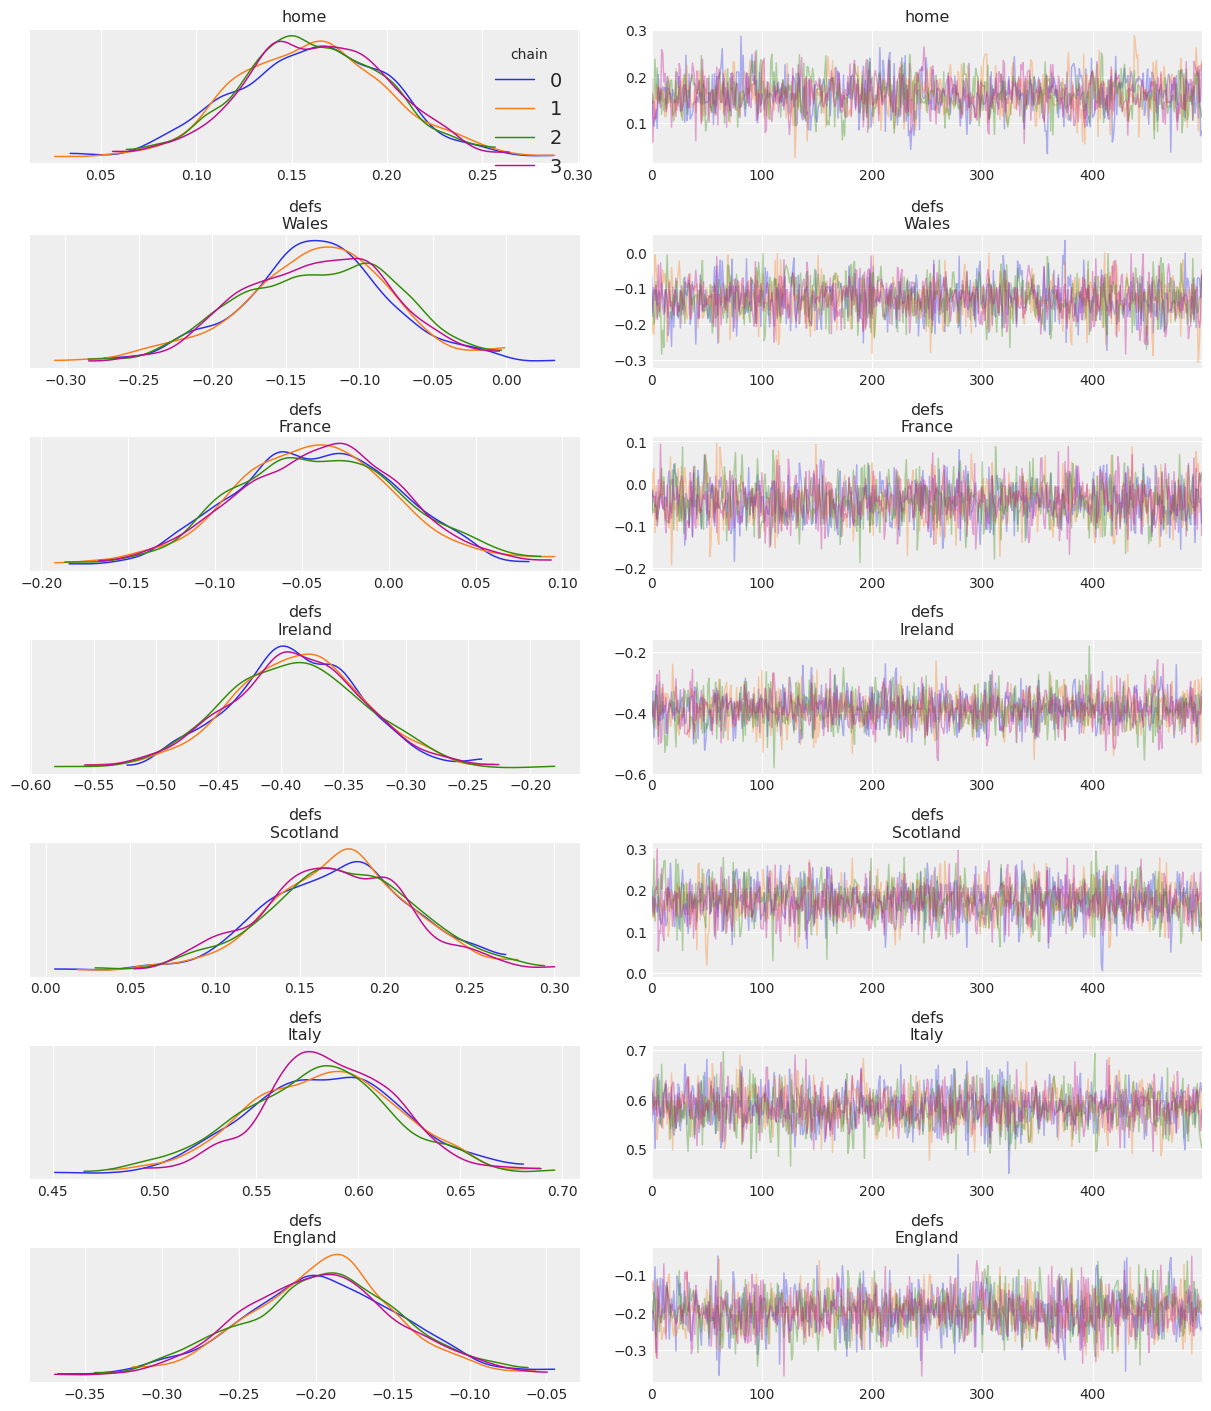

In [14]:
az.plot_trace(idata, var_names=["home", "defs"], legend=True);

### `combined=True` and `compact=False`
Chains are aggregated into a single quantity if possible. Therefore, distribution column will have one line per subplot due to the aggregation but the trace column will be the same as in the previous section.
This is also a chain only setting, the default mapping is to use color to distinguish chains. However, we'll use this example to show usage of `chain_prop` to map the chain to the linewidth:

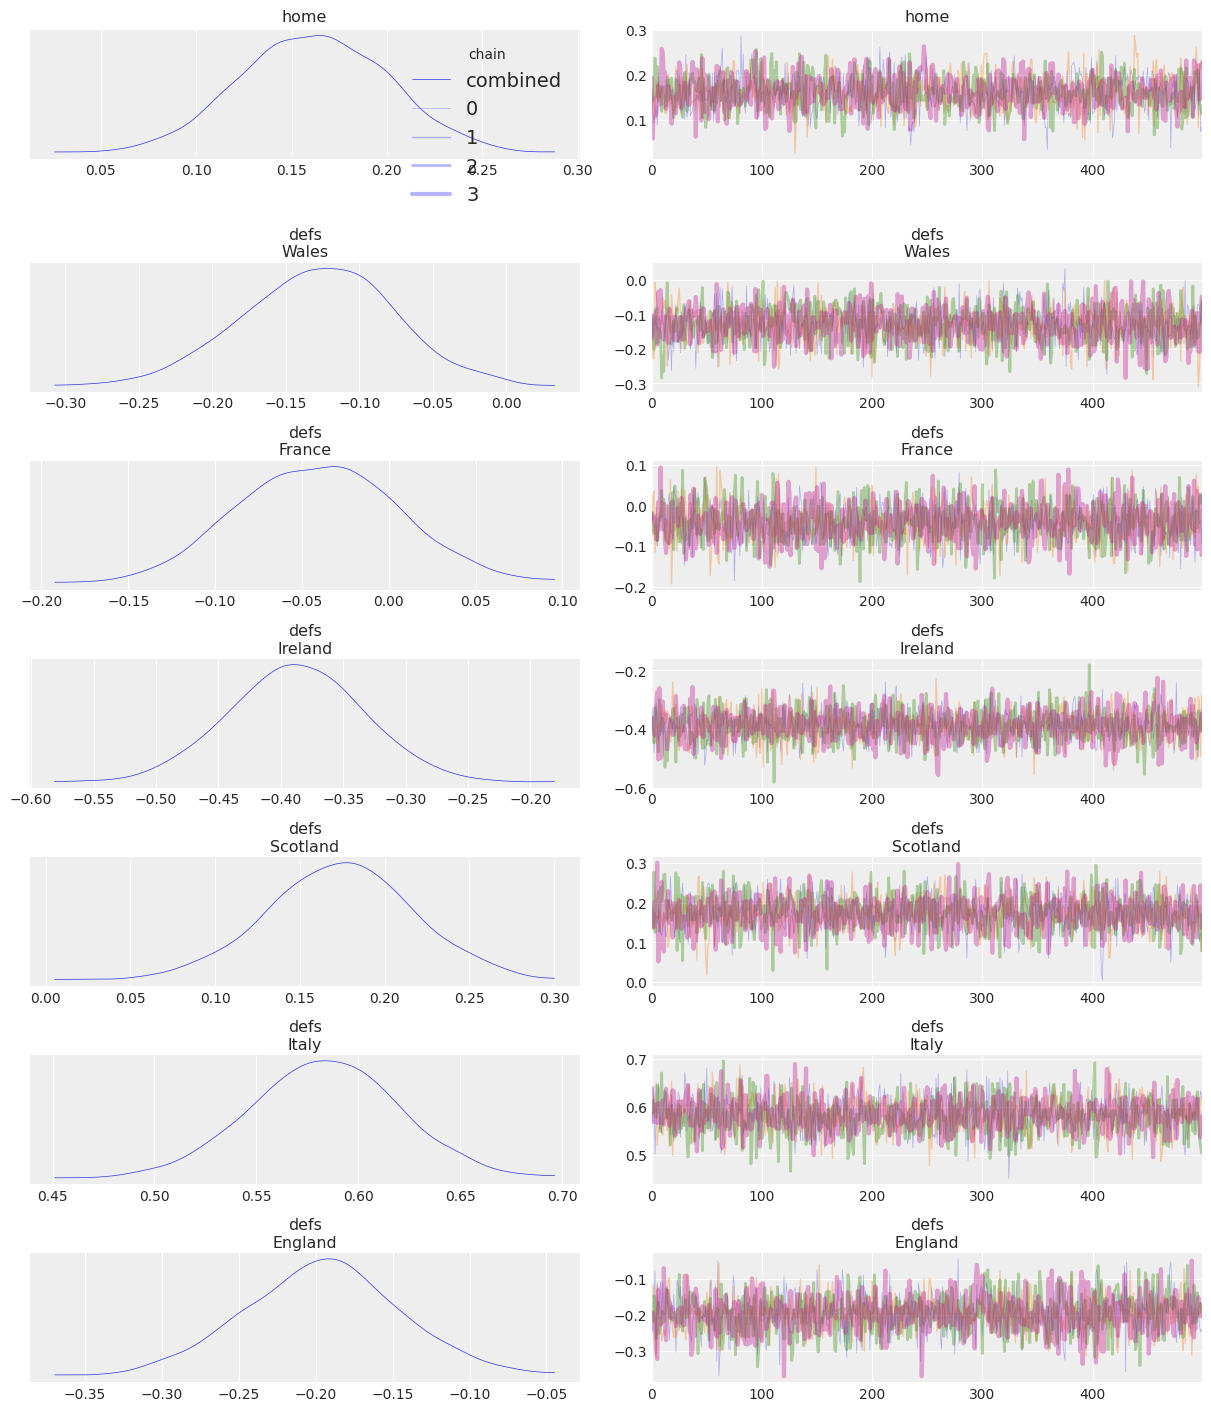

In [15]:
chain_prop = {"linewidth": (.5, 1, 2, 3)}
az.plot_trace(
    idata, var_names=["home", "defs"], combined=True, chain_prop=chain_prop, compact=False, legend=True
);

### `combined=False` and `compact=True`
You are probably tired already from scrolling down and we have only 6 teams! Imagine having a variable with a dimension of length 100 or more :scream:

In these cases, it may be more convenient to analyze a compact version of the trace plot:

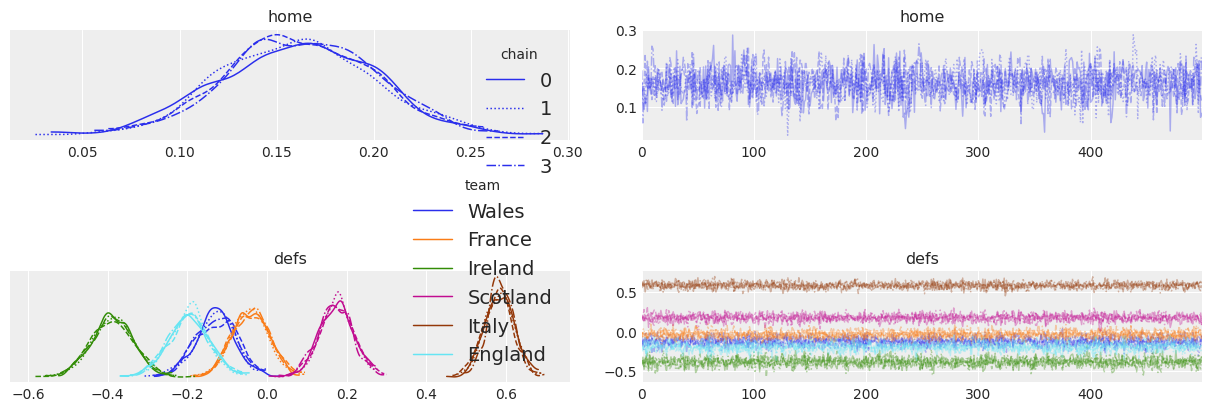

In [16]:
az.plot_trace(idata, var_names=["home", "defs"], combined=False, compact=True, legend=True);

The first two things that jump to the eye are that ArviZ has drastically modified the default aesthetic of the plot and that the plot fits now comfortable in a single screen, bye bye scrolling :wave:

We can also see that `legend=True` has included multiple legends to the figure. The `chain` legend is always included in the top right trace plot, and the plots in the distribution column contain a legend if necessary.

### `combined=True` and `compact=True`
To reduce even more the clutter of lines in the trace plot, we can also combine chains. Moreover, the `linestyle -> chain` mapping can be distracting, especially if we don't care too much about distinguishing the chains between them. Like we did before, we will use `chain_prop` to control this.

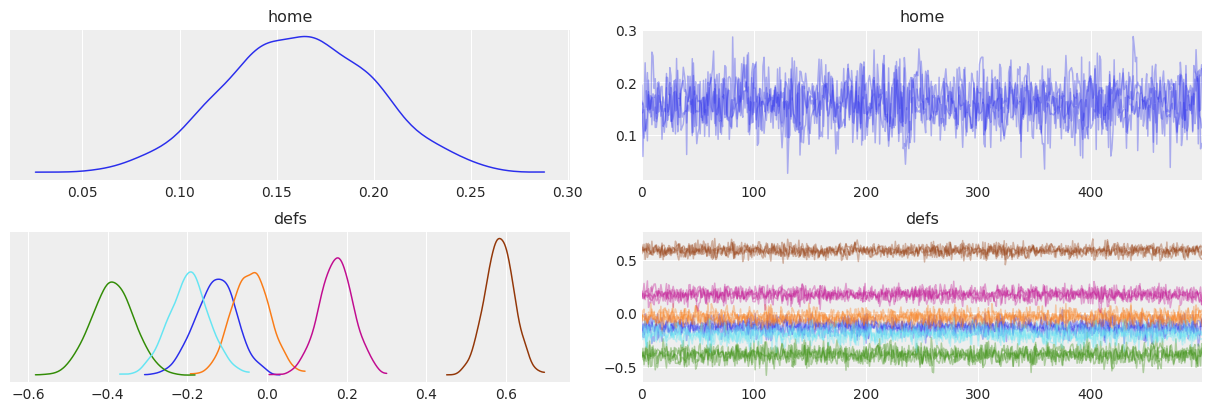

In [17]:
az.plot_trace(idata, var_names=["home", "defs"], combined=True, chain_prop={"ls": "-"}, compact=True);

Finally, we will explore alternative usage options for `chain_prop` and `compact_prop`. In the two previous examples we have used a 2 element tuple where the second position of the tuple contained the properties to use. Another alternative is to pass a string present in `plt.rcParams["axes.prop_cycle"]`, which in our case is `color` only.

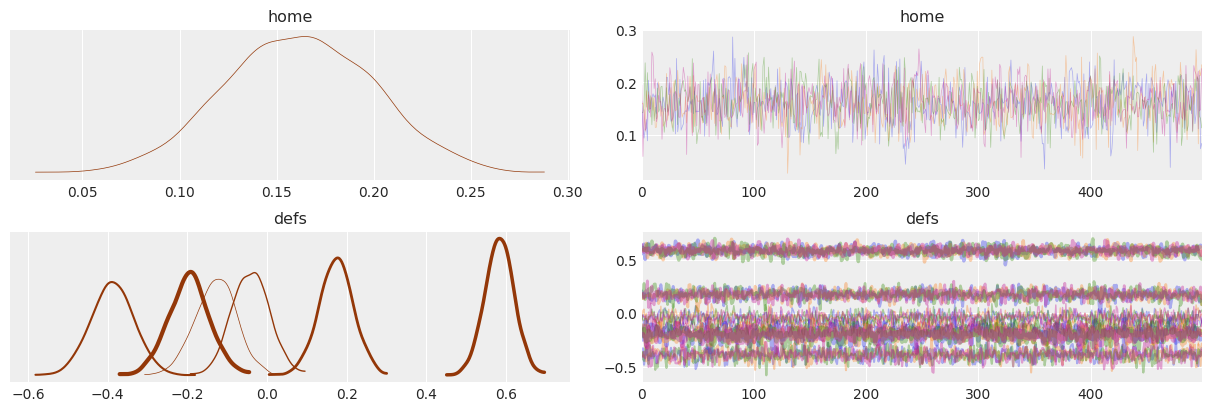

In [18]:
az.plot_trace(
    idata, var_names=["home", "defs"], 
    combined=True, chain_prop="color", 
    compact=True, compact_prop={"lw": np.linspace(.5, 3, 6)}
);

## Summing it all up
Now that we have covered most arguments, let's put everything to practice. Try to generate a trace plot following the instructions below:

* Show variables `home`, `defs` and `atts` showing only `Scotland, Ireland, Italy, Wales` coordinates.
* For `defs` variable, plot lines showing the 70% HDI.
* Map chains to the following colors: `'C0', 'C1', 'C2', 'C3', "xkcd:purple blue"`
* Map team dimension to both linestyle (solid and dashed) and linewidth

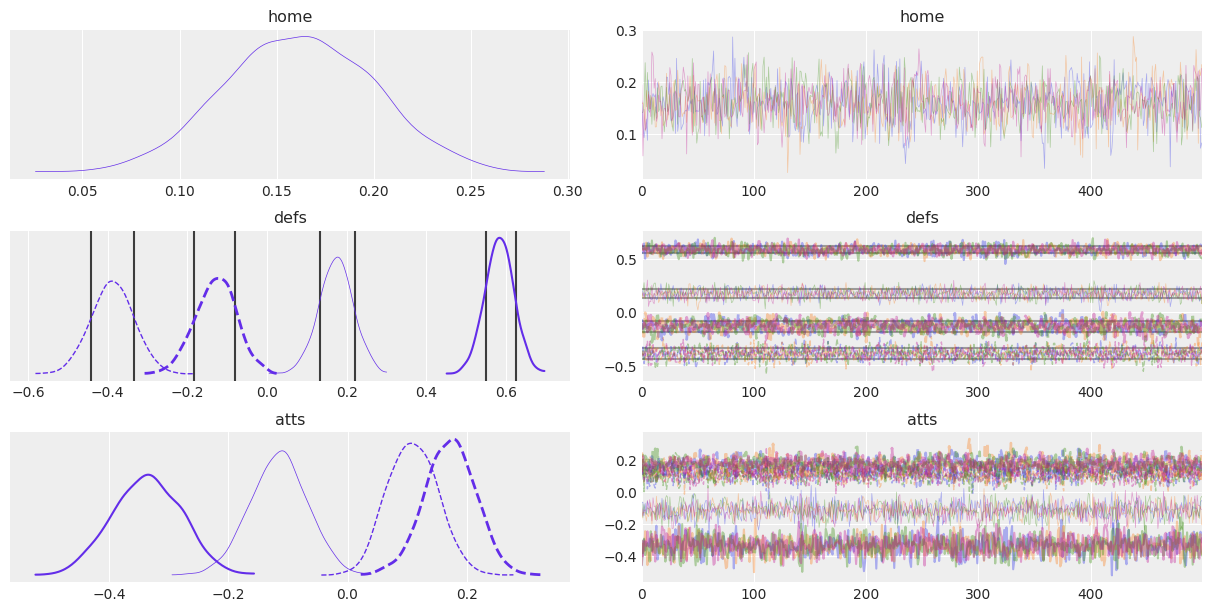

In [19]:
#collapse-hide
coords = {"team": ["Scotland", "Ireland", "Italy", "Wales"]}
quantile_ds = az.hdi(idata, var_names="defs", coords=coords, hdi_prob=.7)
lines = list(xarray_var_iter(quantile_ds, skip_dims={"hdi", "team"}))
chain_prop = {"color": ['C0', 'C1', 'C2', 'C3', "xkcd:purple blue"]}
az.plot_trace(
    idata, var_names=["home", "defs", "atts"], 
    combined=True, chain_prop=chain_prop, 
    compact=True, compact_prop={"lw": np.linspace(.5, 3, 6), "ls": ("-", "--")},
    lines=lines,
    coords=coords
);

Package versions used to generate this post:

In [20]:
#hide_input
%load_ext watermark
%watermark -n -u -v -iv -w

numpy  1.19.0
arviz  0.9.0
xarray 0.15.1
last updated: Mon Jun 29 2020 

CPython 3.6.9
IPython 7.15.0
watermark 2.0.2


---
Comments are not enabled for the blog, to inquiry further about the contents of the post, ask on [ArviZ Issues](https://github.com/arviz-devs/arviz/issues) or [PyMC Discourse](https://discourse.pymc.io/)